In [0]:
# fastai 0.7.0
!mkdir src -p && cd src && git clone https://github.com/fastai/fastai.git
!pip3 install -q bcolz graphviz sklearn_pandas isoweek pandas_summary ipywidgets torch torchvision torchtext
import sys
sys.path.append("/content/src/fastai/old") # on windows use \'s instead
from fastai.conv_learner import *
from fastai.dataset import *
import gc
print(torch.__version__)
torch.backends.cudnn.benchmark=True
torch.cuda.is_available(), torch.backends.cudnn.enabled

Cloning into 'fastai'...
remote: Enumerating objects: 32, done.
remote: Counting objects: 100% (32/32), done.
remote: Compressing objects: 100% (24/24), done.
remote: Total 16102 (delta 17), reused 18 (delta 8), pack-reused 16070
Receiving objects: 100% (16102/16102), 298.57 MiB | 27.68 MiB/s, done.
Resolving deltas: 100% (10829/10829), done.
Checking out files: 100% (695/695), done.
tcmalloc: large alloc 1073750016 bytes == 0x58b94000 @  0x7f7e89a022a4 0x591a07 0x5b5d56 0x502e9a 0x506859 0x502209 0x502f3d 0x506859 0x504c28 0x502540 0x502f3d 0x506859 0x504c28 0x502540 0x502f3d 0x506859 0x504c28 0x502540 0x502f3d 0x507641 0x502209 0x502f3d 0x506859 0x504c28 0x502540 0x502f3d 0x507641 0x504c28 0x502540 0x502f3d 0x507641
0.4.1


(True, True)

In [0]:
!git config --global user.email 'nikshuang@163.com'
!git config --global user.name 'Alex Huang'
!pip install -q kaggle

In [0]:
PATH = Path('data/quick_draw')
TRN_TXT_PATH = PATH/'txt'
TRN_PATH = PATH/'train'
TEST_PATH = PATH/'test'
DISK_PATH = 'drive/quick_draw'
os.makedirs(DISK_PATH, exist_ok=True)
os.makedirs(PATH, exist_ok=True)
os.makedirs(TRN_PATH, exist_ok=True)
os.makedirs(TEST_PATH, exist_ok=True)
os.makedirs(TRN_TXT_PATH, exist_ok=True)

In [0]:
kaggle competitions download -c human-protein-atlas-image-classification -p {PATH}
!cd {PATH}/'tx && unzip -q ../train_simplified.zip

test_simplified.csv: Skipping, found more recently modified local copy (use --force to force download)
train_simplified.zip: Skipping, found more recently modified local copy (use --force to force download)
replace fence.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

### Prepare data: load from *.png

In [0]:
%%time
def get_count(path): return (path.stem, pd.read_csv(path).shape[0])
with ThreadPoolExecutor(2) as e: counts = list(e.map(get_count, TRN_PATH.iterdir()))

In [0]:
counts = sorted(counts, key=lambda x: x[1])

最小的数据集和最大的数据集相差有20多万个样本，数据分布极度不均

In [0]:
counts[:10], counts[-10:]

In [0]:
df = pd.read_csv(TRN_PATH/'blueberry.csv')
df.head()

,countrycode,drawing,key_id,recognized,timestamp,word
0,TH,"[[[47, 39, 22, 12, 0, 0, 2, 7, 17, 42, 50, 62,...",6382699784699904,True,2017-03-16 09:41:33.474350,blueberry
1,IT,"[[[222, 207, 196, 190, 191, 194, 208, 242, 252...",6046664550776832,True,2017-01-23 15:11:32.747510,blueberry
2,US,"[[[189, 186, 170, 126, 82, 60, 31, 8, 1, 0, 11...",5715196523839488,True,2017-01-25 17:51:09.581080,blueberry
3,US,"[[[109, 84, 57, 44, 19, 10, 1, 0, 4, 14, 32, 4...",5147758375731200,True,2017-03-19 13:06:15.610220,blueberry
4,US,"[[[77, 57, 26, 14, 2, 0, 2, 14, 33, 62, 86, 12...",6728861146415104,True,2017-03-06 16:01:44.166140,blueberry


In [0]:
# https://www.kaggle.com/gaborfodor/greyscale-mobilenet-lb-0-892
BASE_SIZE = 256

def draw_cv2(raw_strokes, size=256, lw=4, time_color=False):
    img = np.zeros((BASE_SIZE, BASE_SIZE), np.uint8)
    for t, stroke in enumerate(raw_strokes):
        for i in range(len(stroke[0]) - 1):
            color = 255 - min(t, 10) * 13 if time_color else 255
            _ = cv2.line(img, (stroke[0][i], stroke[1][i]),
                         (stroke[0][i + 1], stroke[1][i + 1]), color, lw)
    img = cv2.copyMakeBorder(img, 4, 4, 4, 4, cv2.BORDER_CONSTANT)
    if size != BASE_SIZE:
        return cv2.resize(img, (size, size), interpolation=cv2.INTER_LINEAR)
    return img

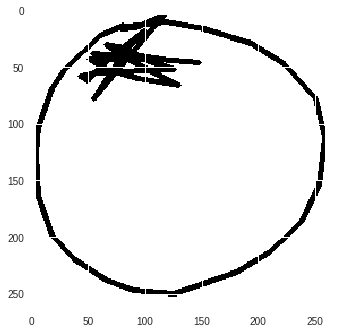

In [0]:
plt.imshow(draw_cv2(eval(df.loc[4, 'drawing']), size=256))

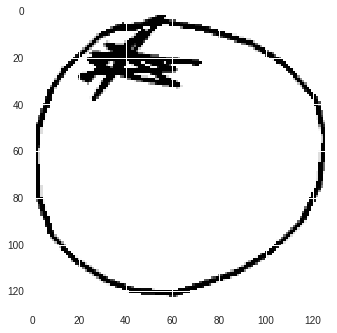

In [0]:
plt.imshow(draw_cv2(eval(df.loc[4, 'drawing']), size=128))

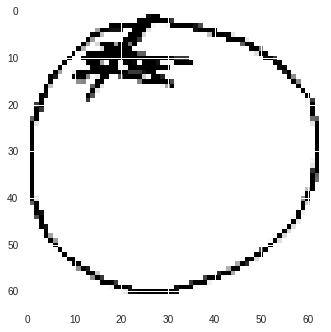

In [0]:
plt.imshow(draw_cv2(eval(df.loc[4, 'drawing']), size=64))

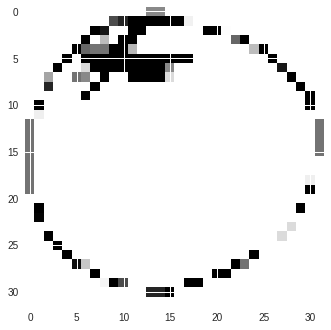

In [0]:
plt.imshow(draw_cv2(eval(df.loc[4, 'drawing']), size=32))

In [0]:
k = 250
sz = 128
mn = f'mobilenet_{sz}sz_{k}'
dn = f'quickdraw_data_{sz}sz_{k}.tar.bz2'
FN_PKL = f'fnames_{sz}sz_{k}.pkl'
VAL_PKL = f'val_idxs_{sz}sz_{k}.pkl'

In [0]:
def df_to_ims(path):
  df = pd.read_csv(path)
  selected = df[df.recognized == True].sample(k)
  for row in selected.iterrows():
    kid, drawing, label = row[1].key_id, eval(row[1].drawing), '_'.join(row[1].word.split())
    ary = draw_cv2(drawing, size=sz)
    rgb_ary = np.repeat(ary[:, :, None], 3, -1)
    plt.imsave(f'{PATH}/train_{sz}/{label}-{kid}.png', rgb_ary)
#     PIL.Image.fromarray(rgb_ary).save(f'{PATH}/train_{sz}/{label}-{kid}.png')

In [0]:
%%time
shutil.rmtree(PATH/f'train_{sz}', ignore_errors=True)
os.makedirs(PATH/f'train_{sz}', exist_ok=True)
with ThreadPoolExecutor(2) as e: e.map(df_to_ims, TRN_PATH.iterdir())

CPU times: user 11min 24s, sys: 44.1 s, total: 12min 8s
Wall time: 9min 39s


In [0]:
!ls {PATH}/train_{sz} -l | wc -l
!ls {PATH}/train_{sz} -lhS | head -5

85001
total 353M
-rw-r--r-- 1 root root 8.4K Nov 10 01:32 camouflage-5968440256888832.png
-rw-r--r-- 1 root root 7.9K Nov 10 01:29 squiggle-5598703249260544.png
-rw-r--r-- 1 root root 7.7K Nov 10 01:30 blackberry-4885994497114112.png
-rw-r--r-- 1 root root 7.6K Nov 10 01:30 blackberry-5734184150630400.png


In [0]:
# PIL.Image.open(PATH/f'train_{sz}/blackberry-4927079281852416.png')

In [0]:
df = pd.read_csv(PATH/'test_simplified.csv')
df.head()

,key_id,countrycode,drawing
0,9000003627287624,DE,"[[[17, 18, 20, 25, 137, 174, 242, 249, 251, 25..."
1,9000010688666847,UA,"[[[174, 145, 106, 38, 11, 4, 4, 15, 29, 78, 16..."
2,9000023642890129,BG,"[[[0, 12, 14, 17, 16, 24, 55, 57, 60, 79, 82, ..."
3,9000038588854897,US,"[[[0, 9, 23, 40, 54, 60, 81, 105, 123, 167, 20..."
4,9000052667981386,AR,"[[[87, 82, 71, 63, 66, 92, 96, 95], [220, 218,..."


In [0]:
def test_df_to_ims(path):
  df = pd.read_csv(path)
  for row in df.iterrows():
    kid, drawing = row[1].key_id, eval(row[1].drawing)
    ary = draw_cv2(drawing, size=sz)
    rgb_ary = np.repeat(ary[:, :, None], 3, -1)
    plt.imsave(f'{PATH}/test_{sz}/{kid}.png', rgb_ary)
#     PIL.Image.fromarray(rgb_ary).save(f'{PATH}/test_{sz}/{kid}.png')

In [0]:
%%time
shutil.rmtree(PATH/f'test_{sz}', ignore_errors=True)
os.makedirs(PATH/f'test_{sz}', exist_ok=True)
test_df_to_ims(PATH/'test_simplified.csv')

CPU times: user 5min 33s, sys: 8.72 s, total: 5min 42s
Wall time: 5min 42s


In [0]:
!ls {PATH}/test_{sz} -l | wc -l
!ls -lhS {PATH}/test_{sz} | head -5

112200
total 501M
-rw-r--r-- 1 root root 7.7K Nov 10 01:41 9831494525348231.png
-rw-r--r-- 1 root root 7.6K Nov 10 01:39 9525461686320036.png
-rw-r--r-- 1 root root 7.5K Nov 10 01:40 9679715569692673.png
-rw-r--r-- 1 root root 7.5K Nov 10 01:39 9534292565812127.png


In [0]:
# PIL.Image.open(f'{PATH}/test_{sz}/9985742567546855.png')

In [0]:
%%time
!cd {PATH} && tar jcf {dn} train_{sz} test_{sz}
shutil.copy(f'{PATH}/{dn}', DISK_PATH)

In [0]:
image_exts = ['.jpg', '.jpeg', '.png']
def get_image_files(path, check_ext=True, recurse=False):
  return [o for o in Path(path).glob('**/*' if recurse else '*')
          if not o.name.startswith('.') and not o.is_dir()
          and (not check_ext or o.suffix in image_exts)]

In [0]:
fnames = get_image_files(PATH/f'train_{sz}')
val_idxs = get_cv_idxs(len(fnames))
len(val_idxs), val_idxs[:2], len(fnames), fnames[:3]

(17000,
 array([20569,  6186]),
 85000,
 [PosixPath('data/quick_draw/train_128/animal_migration-6466977700773888.png'),
  PosixPath('data/quick_draw/train_128/bandage-6028172833325056.png'),
  PosixPath('data/quick_draw/train_128/fan-5967909526437888.png')])

In [0]:
with open(FN_PKL, 'wb') as fp:
  pickle.dump(fnames, fp)
with open(VAL_PKL, 'wb') as fp:
  pickle.dump(val_idxs, fp)
shutil.copy(f'{FN_PKL}', DISK_PATH)
shutil.copy(f'{VAL_PKL}', DISK_PATH)

'drive/quick_draw/val_idxs_128sz_250.pkl'

### Prepare data: load from *.txt

In [0]:
NUM_SAMPLES_PER_CLASS = 200

def create_train_txts_from_df(path):
    df = pd.read_csv(path, nrows=NUM_SAMPLES_PER_CLASS)
    klass = '_'.join(path.stem.split())
    drawings = df.drawing.values
    for i, drawing in enumerate(drawings):
        fpth = TRN_PATH/f'{klass}-{i}.txt'
        if fpth.exists(): continue
        with open(fpth, mode='w') as f: f.write(drawing)

def create_test_txts_from_df(path):
    df = pd.read_csv(path)
    kids = df.key_id.values
    drawings = df.drawing.values
    for kid, drawing in zip(kids, drawings):
        with open(TEST_PATH/f'{kid}.txt', mode='w') as f: f.write(drawing)

In [0]:
%%time
with ThreadPoolExecutor(2) as e: e.map(create_train_txts_from_df, TRN_TXT_PATH.iterdir())

CPU times: user 12.4 s, sys: 11.2 s, total: 23.6 s
Wall time: 15.4 s


In [0]:
create_test_txts_from_df(PATH/'test_simplified.csv')

In [0]:
drawing_exts = ['.txt']
def get_image_files(path, check_ext=True, recurse=False):
  return [o for o in Path(path).glob('**/*' if recurse else '*')
          if not o.name.startswith('.') and not o.is_dir()
          and (not check_ext or o.suffix in drawing_exts)]

fnames = get_image_files(TRN_PATH)
test_fnames = get_image_files(TEST_PATH)
val_idxs = get_cv_idxs(len(fnames))
len(val_idxs), val_idxs[:2], len(fnames), fnames[:2]

(13600,
 array([23742, 59794]),
 68000,
 [PosixPath('data/quick_draw/train/pliers-101.txt'),
  PosixPath('data/quick_draw/train/grapes-137.txt')])

In [0]:
labels = np.array([o.name.split('-')[0] for o in fnames])
len(labels), labels[:5]

(68000,
 array(['pliers', 'grapes', 'spreadsheet', 'calendar', 'pool'], dtype='<U23'))

In [0]:
classes = np.unique(labels)

In [0]:
x_names = np.array(['train/' + o.name for o in fnames])
test_x_names = np.array(['test/' + o.name for o in test_fnames])
x_names[:2], test_x_names[:2]

(array(['train/pliers-101.txt', 'train/grapes-137.txt'], dtype='<U37'),
 array(['test/9294575425747848.txt', 'test/9854825525933368.txt'], dtype='<U25'))

In [0]:
((val_x, trn_x), (val_y, trn_y)) = split_by_idx(val_idxs, x_names, labels)
len(trn_x), len(trn_y), len(val_x), len(val_y)

(54400, 54400, 13600, 13600)

In [0]:
colors = [(255, 0, 0) , (255, 255, 0),  (128, 255, 0),  (0, 255, 0), (0, 255, 128), (0, 255, 255), 
          (0, 128, 255), (0, 0, 255), (128, 0, 255), (255, 0, 255)]
BASE_SIZE = 256

def draw_cv2(raw_strokes, size=256, lw=7, time_color=True):
    img = np.zeros((BASE_SIZE, BASE_SIZE, 3), np.uint8)
    for t, stroke in enumerate(raw_strokes):
        for i in range(len(stroke[0]) - 1):
            color = colors[min(t, len(colors)-1)]
            _ = cv2.line(img, (stroke[0][i], stroke[1][i]),
                         (stroke[0][i + 1], stroke[1][i + 1]), color, lw, lineType=cv2.LINE_AA)
    if size != BASE_SIZE:
        return cv2.resize(img, (size, size), interpolation=cv2.INTER_LINEAR)
    else:
        return img

def gen_img(path):
    with open(path) as f: drawing = eval(f.read())
    return draw_cv2(drawing, size=sz)

def open_image(fn):
    if not os.path.exists(fn) and not str(fn).startswith("http"):
        raise OSError('No such file or directory: {}'.format(fn))
    elif os.path.isdir(fn) and not str(fn).startswith("http"):
        raise OSError('Is a directory: {}'.format(fn))
    else:
        try:
            return gen_img(str(fn)).astype(np.float32) / 255
        except Exception as e:
            raise OSError('Error handling image at: {}'.format(fn)) from e

class DrawingDataset(FilesDataset):
    def __init__(self, fnames, y, tfm, path, classes):
        assert isinstance(classes, (list, np.ndarray)), 'classes must be label list.'
        self.y, self.c = y, len(classes)
        self.cls2id = {o:i for i, o in enumerate(classes)}
        super().__init__(fnames, tfm, path)
        
    def get_y(self, i): return self.cls2id[self.y[i]]
    def get_x(self, i): return open_image(os.path.join(self.path, self.fnames[i]))
    def get_c(self): return self.c

In [0]:
arch = resnet34
bs = 640
sz = 128

aug_tfms = [
    RandomFlip(),
#     RandomRotate(5, p=0.5),
    RandomLighting(0.05, 0.05)
]

tfms = tfms_from_model(arch, sz, aug_tfms=aug_tfms, max_zoom=1.05)
ds = ImageData.get_ds(DrawingDataset, (trn_x, trn_y), (val_x, val_y), tfms, test=test_x_names, path=PATH, classes=classes)
md = ImageData(PATH, ds, bs, num_workers=8, classes=classes)
md.c, md.classes[:3]

(340,
 array(['The_Eiffel_Tower', 'The_Great_Wall_of_China', 'The_Mona_Lisa'], dtype='<U23'))

In [0]:
%time x, y = next(iter(md.trn_dl))

CPU times: user 25.4 s, sys: 7.21 s, total: 32.6 s
Wall time: 19.6 s


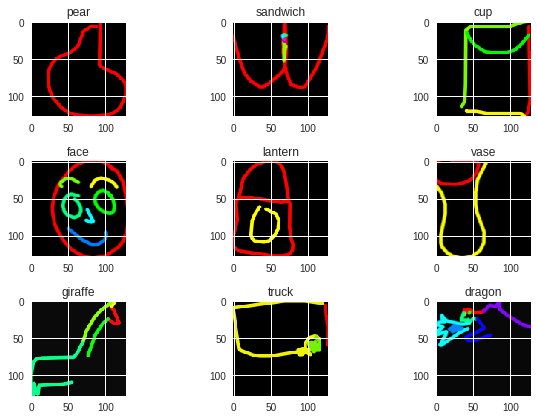

In [0]:
x = md.trn_ds.denorm(x)
fig, axes = plt.subplots(3, 3, figsize=(9, 6))
for i, ax in enumerate(axes.flat):
  ax.imshow(x[i])
  ax.set_title(md.classes[y[i]])
plt.tight_layout()

### MobileNet

In [0]:
mn = f'mobilenet_{sz}sz'
mn

'mobilenet_128sz'

In [0]:
def std_conv(nin, nf, ks=3, stride=1):
  return nn.Sequential(
      nn.Conv2d(nin, nf, ks, stride, padding=ks//2, bias=False),
      nn.BatchNorm2d(nf),
      nn.ReLU(inplace=True)
#       nn.LeakyReLU(inplace=True)
  )

def conv_dw(nin, nf, stride=2):
  return nn.Sequential(
      nn.Conv2d(nin, nin, 3, stride, 1, groups=nin, bias=False),
      nn.BatchNorm2d(nin),
      nn.ReLU(inplace=True),
#       nn.LeakyReLU(inplace=True),
      nn.Conv2d(nin, nf, 1, 1, bias=False),
      nn.BatchNorm2d(nf),
      nn.ReLU(inplace=True)
#       nn.LeakyReLU(inplace=True)
  )

class MobileNet(nn.Module):
  def __init__(self, num_classes, nf=512, ps=[0.25, 0.5]):
    super().__init__()
    self.layers = nn.Sequential(
        std_conv(3, 32, 2),
        conv_dw(32, 64, 1),
        conv_dw(64, 128),
        conv_dw(128, 128, 1),
        conv_dw(128, 256),
        conv_dw(256, 256, 1),
        conv_dw(256, 512),
        conv_dw(512, 512, 1),
        conv_dw(512, 512, 1),
        conv_dw(512, 512, 1),
        conv_dw(512, 512, 1),
        conv_dw(512, 512, 1),
        conv_dw(512, 1024, 2),
        conv_dw(1024, 1024, 1),
        nn.AdaptiveAvgPool2d(1),
        Flatten(),
        nn.BatchNorm1d(1024),
        nn.Dropout(p=ps[0]),
        nn.Linear(1024, nf),
        nn.ReLU(),
        nn.BatchNorm1d(nf),
        nn.Dropout(p=ps[1]),
        nn.Linear(nf, num_classes),      
        nn.LogSoftmax()
    )

  def forward(self, x):
    return self.layers(x)

In [0]:
def map_top3(preds, targs):
  top5 = torch.sort(preds, dim=1, descending=True)[0][:, :3]
  return torch.mean(torch.sum(torch.exp(top5), 1))

In [0]:
ps = [0.25, 0.5]
nf = 512

m = to_gpu(MobileNet(md.c, nf, ps))
learn = ConvLearner.from_model_data(m, md)
# learn.cirt = nn.CrossEntropyLoss()
learn.metrics = [accuracy, map_top3]

In [0]:
# load_model_weights(subdir='20181105')
# learn.load('mobilenet_64sz_5k')

 87%|████████▋ | 743/850 [08:42<01:17,  1.37it/s, loss=24.3]

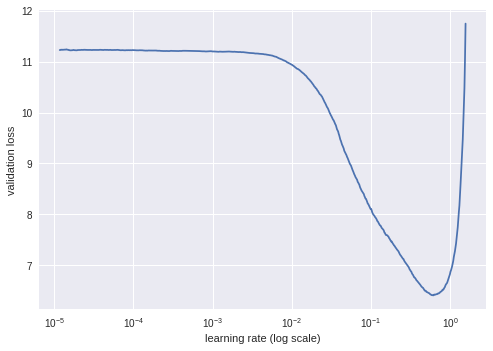

In [0]:
learn.lr_find()
learn.sched.plot()

In [0]:
lr = 8e-2
learn.fit(lr, 1, cycle_len=10, use_clr=(20, 10))
learn.save(mn)

epoch      trn_loss   val_loss   accuracy   map_top3   
    0      4.221134   3.929499   0.174265   0.373     
    1      3.122172   2.83353    0.352059   0.528392  
    2      2.647427   2.299856   0.460735   0.640049  
    3      2.421247   2.322631   0.454706   0.634115  
    4      2.163204   1.90709    0.545147   0.721836  
    5      1.975682   1.765632   0.575662   0.747461  
    6      1.821589   1.665574   0.603162   0.768702  
    7      1.698267   1.60571    0.617794   0.786565  
    8      1.58901    1.53894    0.634118   0.807489  
    9      1.459088   1.491365   0.644044   0.82133   


### Resnet34

In [0]:
models = ConvnetBuilder(arch, len(classes), False, False)
learn = ConvLearner(md, models)

epoch      trn_loss   val_loss   accuracy   
    0      5.329136   5.645055   0.206324  



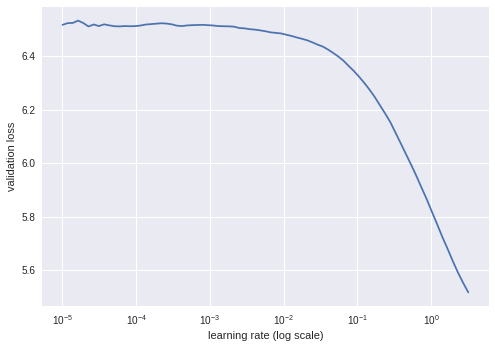

In [0]:
learn.lr_find()
learn.sched.plot(0)

In [0]:
lr = 4e-1
learn.fit(lr, 2, cycle_len=1, cycle_mult=2)

epoch      trn_loss   val_loss   accuracy   
    0      3.799521   3.013281   0.344265  
    1      3.202584   2.542      0.418088  
    2      2.804773   2.404532   0.445515  



[2.4045316331526814, 0.4455147070043227]

epoch      trn_loss   val_loss   accuracy   
    0      3.380707   10646.408054 0.003162  



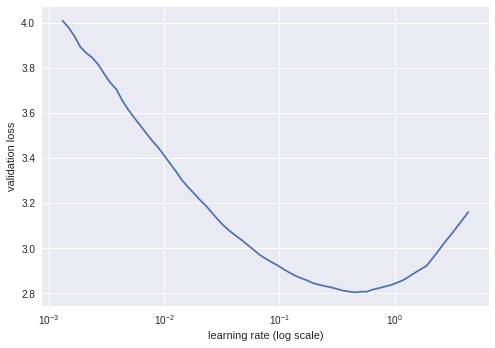

In [0]:
learn.unfreeze()
learn.lr_find(lr / 1000)
learn.sched.plot()

In [0]:
lr = 8e-4
lrs = np.array([lr / 9, lr / 3, lr])
learn.fit(lrs, 3, cycle_len=2, cycle_mult=2)

epoch      trn_loss   val_loss   accuracy   
    0      2.496831   2.085892   0.510588  
    1      2.305883   2.030547   0.520294  
    2      2.123826   1.874482   0.554559  
    3      2.017922   1.802687   0.5675    
    4      1.924573   1.772526   0.577059  
    5      1.901727   1.768791   0.578382  
    6      1.890097   1.712933   0.589559  
    7      1.868803   1.668383   0.597059  
    8      1.666557   1.637589   0.605     
    9      1.597122   1.614383   0.608088  
    10     1.609161   1.599738   0.610882  
    11     1.522107   1.590971   0.613529  
    12     1.544126   1.593027   0.612059  
    13     1.543969   1.589572   0.613603  


[1.5895717581580666, 0.6136029411764706]

In [0]:
pa = f'resnet34_{sz}sz'
learn.save(pa)

In [0]:
learn.metrics = [accuracy, map_top3]

In [0]:
save_model_weights()

In [0]:
learn.fit(lrs, 1, cycle_len=10, use_clr=(20, 10))

### Submission

In [0]:
preds = learn.TTA(is_test=True)[0]

In [0]:
preds.shape

(5, 112199, 340)

In [0]:
pr = np.mean(np.exp(preds), 0)
pr.shape

(112199, 340)

In [0]:
top_3 = np.argsort(pr)[:, ::-1][:, :3]
cat = np.array([' '.join(str(md.classes[i]) for i in o) for o in top_3])
image = md.test_ds.fnames

In [0]:
submission = pd.DataFrame({'key_id': image, 'word': cat})
submission.head()

,key_id,word
0,test_128/9028014602137518.png,banana elbow matches
1,test_128/9325698402591604.png,paint_can hot_tub cake
2,test_128/9791244567109262.png,string_bean feather dolphin
3,test_128/9396277400422292.png,bulldozer tractor car
4,test_128/9037773561277176.png,flamingo giraffe saxophone


In [0]:
submission.key_id = submission.key_id.str.replace('^test_128/', '')
# submission.key_id = submission.key_id.str.replace('^test_64/', '')
# submission.key_id = submission.key_id.str.replace('^test_32/', '')
submission.key_id = submission.key_id.str.replace('.png$', '')
submission.head()

,key_id,word
0,9028014602137518,banana elbow matches
1,9325698402591604,paint_can hot_tub cake
2,9791244567109262,string_bean feather dolphin
3,9396277400422292,bulldozer tractor car
4,9037773561277176,flamingo giraffe saxophone


In [0]:
submission.to_csv('submission.csv.gz', index=False, compression='gzip')

In [0]:
!kaggle competitions submit -c quickdraw-doodle-recognition -f submission.csv.gz -m ""

100% 1.57M/1.57M [00:04<00:00, 348kB/s]
Successfully submitted to Quick, Draw! Doodle Recognition Challenge

In [0]:
!kaggle competitions submissions -c quickdraw-doodle-recognition

fileName           date                 description  status    publicScore  privateScore  
-----------------  -------------------  -----------  --------  -----------  ------------  
submission.csv.gz  2018-11-10 07:05:27               complete  0.788        None          
submission.csv.gz  2018-11-06 08:23:56               complete  0.833        None          
submission.csv.gz  2018-11-06 08:22:05               error     None         None          
submission.csv.gz  2018-11-01 09:31:01               complete  0.740        None          
submission.csv     2018-11-01 09:26:52               error     None         None          
